# Stress Testing Framework

This notebook implements comprehensive stress testing scenarios for perpetual markets. We simulate extreme market conditions to understand potential risks and ensure system resilience.

## Executive Summary

Stress testing reveals how markets behave under extreme conditions:
- **Liquidation Cascades**: Forced selling creating feedback loops
- **Gap Risk**: Sudden price movements overwhelming liquidity
- **Correlation Breaks**: Normally stable relationships failing
- **Funding Stress**: Extreme funding rates impacting positions

Our framework quantifies potential losses and identifies breaking points before they occur in live markets.

In [1]:
# Essential imports
import sys
sys.path.append('../src')

from risk_model.notebook_helpers import (
    fetch_market_data, run_stress_test_suite, calculate_risk_metrics_all
)
from risk_model.chart_config import setup_chart_style, COLORS
from risk_model.scenario_config import (
    COMPOSITE_STRESS_SCENARIOS, FUNDING_SCENARIOS,
    DEFAULT_ANALYSIS_PARAMS
)
from risk_model.scenarios import (
    simulate_liquidation_cascade, simulate_liquidity_gap,
    analyze_funding_stress, generate_scenario_report
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

setup_chart_style()

## 1. Stress Testing Methodology

### Scenario Design Principles

Our stress tests are based on:
1. **Historical Precedents**: Past market crashes and liquidation events
2. **Theoretical Extremes**: Mathematically possible but unprecedented scenarios
3. **Systemic Risks**: Correlated failures across multiple markets
4. **Operational Failures**: Exchange outages, oracle failures, network congestion

### Key Stress Scenarios

| Scenario | Description | Probability | Impact |
|----------|-------------|-------------|--------|
| Flash Crash | 20%+ price drop in minutes | Low | Extreme |
| Liquidation Cascade | Sequential forced closures | Medium | High |
| Liquidity Drought | 90% reduction in depth | Low | High |
| Funding Squeeze | Extreme funding rates | Medium | Medium |
| Black Swan | Unprecedented 50%+ move | Very Low | Extreme |

In [2]:
# Load market data and prepare for stress testing
from risk_model.config import load_markets_config
markets_config = load_markets_config()
markets = markets_config['markets']
market_data = fetch_market_data(markets, lookback_days=30, limit_markets=5)

# Select top markets by volume for detailed analysis
test_markets = list(market_data.keys())[:5]
print(f"\n🎯 Running stress tests on: {', '.join(test_markets)}")

/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()


/Users/msmart/clob-risk-modelling/risk-model/notebooks/../src/risk_model/volume_analysis.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = klines_df.groupby(price_bins)['volume'].sum()
Failed to fetch data for MATIC-PERP: 'bids'



🎯 Running stress tests on: ETH-PERP, BTC-PERP, SOL-PERP, ARB-PERP


## 2. Liquidation Cascade Analysis

Liquidation cascades occur when initial forced closures trigger further liquidations through price impact. This creates a feedback loop that can devastate market stability.

### Cascade Mechanics
1. **Initial Trigger**: Large position gets liquidated
2. **Price Impact**: Liquidation selling moves price
3. **Margin Calls**: Price move triggers more liquidations
4. **Amplification**: Each wave increases severity

We simulate cascades of varying intensity to identify critical thresholds.

In [3]:
# Run liquidation cascade simulations using configured scenarios
cascade_results = {}
liquidation_scenarios = DEFAULT_ANALYSIS_PARAMS['liquidation_scenarios']

for market in test_markets:
    if market in market_data and 'orderbook' in market_data[market]:
        results = []
        for scenario in liquidation_scenarios:
            result = simulate_liquidation_cascade(
                market_data[market]['orderbook'],
                liquidation_pct=scenario
            )
            result['scenario'] = f"{int(scenario*100)}% OI"
            results.append(result)
        cascade_results[market] = pd.DataFrame(results)

# Display cascade impact summary
print("\n💥 Liquidation Cascade Impact Summary:")
for market, results in cascade_results.items():
    print(f"\n{market}:")
    display(results[['scenario', 'price_impact_pct', 'max_price_drop', 'recovery_bps']].round(2))


💥 Liquidation Cascade Impact Summary:

ETH-PERP:


,scenario,price_impact_pct,max_price_drop,recovery_bps
0,10% OI,0.01,0.01,0.06
1,20% OI,0.01,0.01,0.11
2,40% OI,0.01,0.01,0.13



BTC-PERP:


,scenario,price_impact_pct,max_price_drop,recovery_bps
0,10% OI,0.0,0.0,0.0
1,20% OI,0.0,0.0,0.0
2,40% OI,0.0,0.0,0.0



SOL-PERP:


,scenario,price_impact_pct,max_price_drop,recovery_bps
0,10% OI,0.09,0.09,0.88
1,20% OI,0.14,0.14,1.41
2,40% OI,0.21,0.21,2.09



ARB-PERP:


,scenario,price_impact_pct,max_price_drop,recovery_bps
0,10% OI,0.22,0.22,2.17
1,20% OI,0.31,0.31,3.14
2,40% OI,0.60,0.60,6.04


## 3. Gap Risk Scenarios

Gap risk occurs when prices move suddenly without intermediate trades, often due to:
- Major news events
- Oracle manipulation
- Cross-exchange arbitrage failures
- Network congestion preventing trading

These gaps can leave positions underwater instantly, bypassing normal risk management.

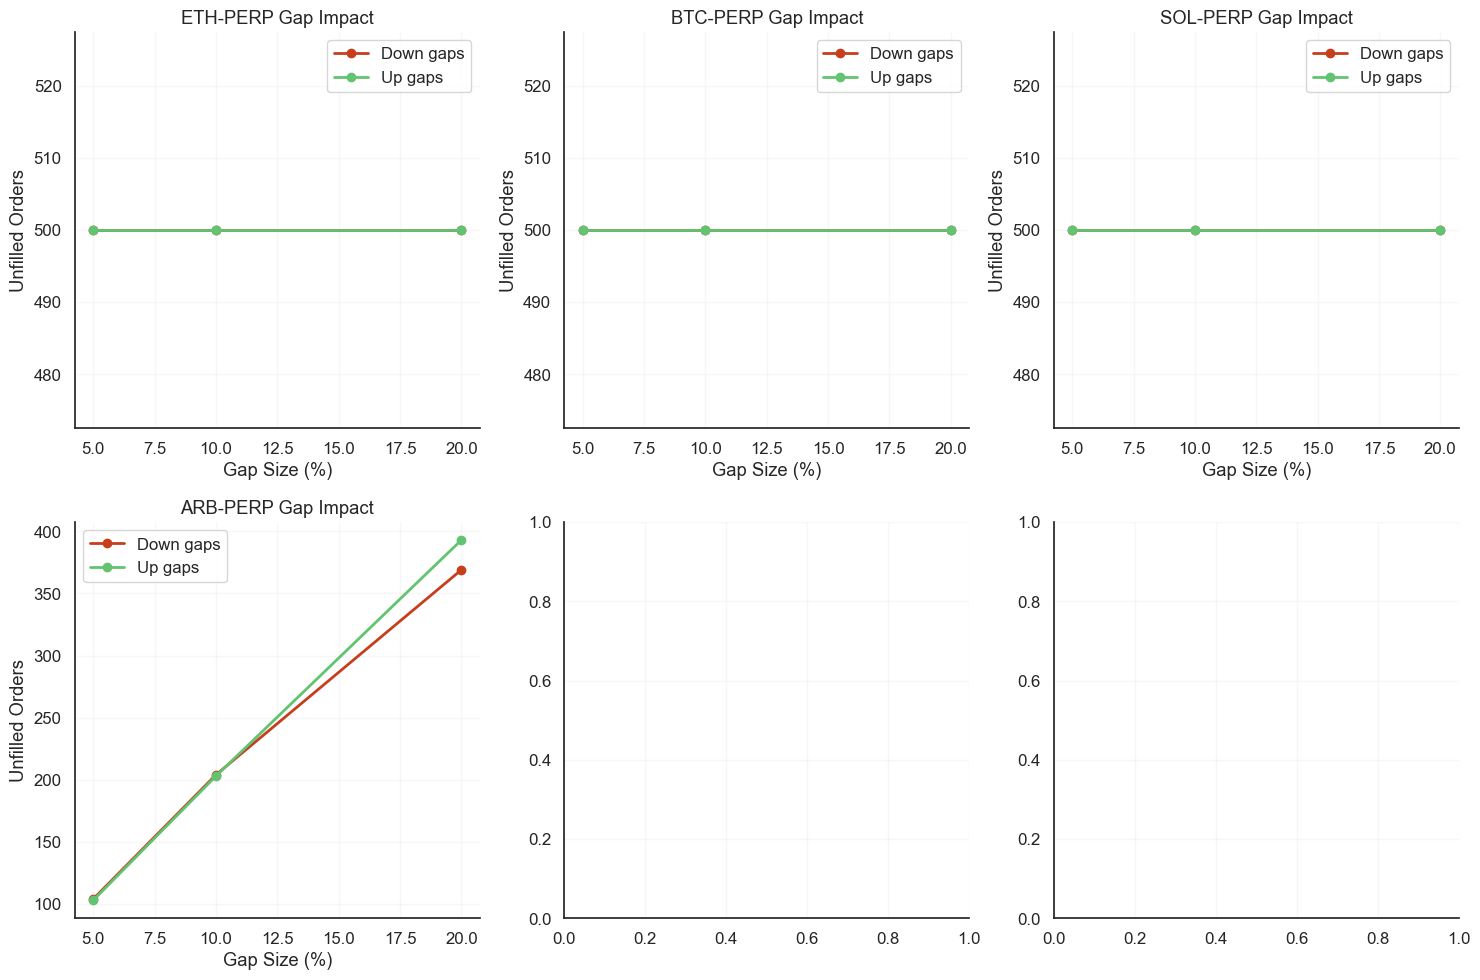

In [4]:
# Simulate gap scenarios using configured parameters
gap_scenarios = DEFAULT_ANALYSIS_PARAMS['gap_scenarios']
gap_results = {}

for market in test_markets:
    if market in market_data and 'orderbook' in market_data[market]:
        results = []
        for gap_size in gap_scenarios:
            # Simulate both up and down gaps
            for direction in ['down', 'up']:
                result = simulate_liquidity_gap(
                    market_data[market]['orderbook'],
                    gap_size=gap_size,
                    direction=direction
                )
                result['scenario'] = f"{int(gap_size*100)}% {direction}"
                results.append(result)
        gap_results[market] = pd.DataFrame(results)

# Visualize gap impact
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (market, results) in enumerate(gap_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        down_gaps = results[results['scenario'].str.contains('down')]
        up_gaps = results[results['scenario'].str.contains('up')]
        
        x = [int(g*100) for g in gap_scenarios]
        ax.plot(x, down_gaps['unfilled_orders'].values, 
                color=COLORS['danger'], marker='o', label='Down gaps', linewidth=2)
        ax.plot(x, up_gaps['unfilled_orders'].values, 
                color=COLORS['success'], marker='o', label='Up gaps', linewidth=2)
        
        ax.set_title(f'{market} Gap Impact')
        ax.set_xlabel('Gap Size (%)')
        ax.set_ylabel('Unfilled Orders')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Funding Rate Stress Testing

Extreme funding rates can force position closures even without price movements. We test scenarios where:
- Funding rates spike to unsustainable levels
- Funding remains elevated for extended periods
- Funding flips violently between positive/negative

These scenarios help identify funding-driven liquidation risks.

In [5]:
# Analyze funding stress scenarios using configured parameters
funding_impact = pd.DataFrame()

for scenario_name, params in FUNDING_SCENARIOS.items():
    for market in test_markets[:3]:  # Test on top 3 markets
        if market in market_data:
            result = analyze_funding_stress(
                market_data[market],
                funding_rate=params['rate']/100,
                periods=params['duration']
            )
            result['scenario'] = scenario_name
            result['market'] = market
            funding_impact = pd.concat([funding_impact, pd.DataFrame([result])])

# Pivot for analysis
funding_pivot = funding_impact.pivot_table(
    index='market', 
    columns='scenario', 
    values='total_cost_pct'
)

print("\n💰 Funding Rate Stress Impact (% of Position):")
display(funding_pivot.round(2))


💰 Funding Rate Stress Impact (% of Position):


scenario,crisis,elevated,extreme,normal
market,,,,
BTC-PERP,24.0,0.3,4.0,0.01
ETH-PERP,24.0,0.3,4.0,0.01
SOL-PERP,24.0,0.3,4.0,0.01


## 5. Composite Stress Scenarios

Real crises often involve multiple stressors simultaneously. We model complex scenarios combining:
- Liquidations + Gap risk
- Funding stress + Volatility spikes
- Liquidity drought + Correlation breaks

These compound scenarios reveal hidden vulnerabilities.

In [6]:
# Run composite scenarios using configured parameters
composite_results = {}

for scenario_name, params in COMPOSITE_STRESS_SCENARIOS.items():
    scenario_impact = []
    
    for market in test_markets[:3]:
        if market in market_data:
            # Simulate combined effects
            total_impact = 0
            
            # Liquidation impact
            liq_result = simulate_liquidation_cascade(
                market_data[market]['orderbook'],
                liquidation_pct=params['liquidation_pct']
            )
            total_impact += liq_result['price_impact_pct']
            
            # Gap impact
            gap_result = simulate_liquidity_gap(
                market_data[market]['orderbook'],
                gap_size=params['gap_size'],
                direction='down'
            )
            total_impact += params['gap_size'] * 100
            
            # Liquidity reduction impact
            total_impact *= (1 + params['liquidity_reduction'])
            
            scenario_impact.append({
                'market': market,
                'total_impact_pct': total_impact,
                'survival_probability': max(0, 100 - total_impact),
                'recovery_hours': total_impact * 2  # Rough estimate
            })
    
    composite_results[scenario_name] = pd.DataFrame(scenario_impact)

# Display scenario comparison
print("\n🌪️  Composite Stress Scenario Results:")
for scenario, results in composite_results.items():
    print(f"\n{scenario}:")
    display(results.round(1))


🌪️  Composite Stress Scenario Results:

Market Crash:


,market,total_impact_pct,survival_probability,recovery_hours
0,ETH-PERP,17.0,83.0,34.0
1,BTC-PERP,17.0,83.0,34.0
2,SOL-PERP,17.3,82.7,34.7



Death Spiral:


,market,total_impact_pct,survival_probability,recovery_hours
0,ETH-PERP,38.0,62.0,76.1
1,BTC-PERP,38.0,62.0,76.0
2,SOL-PERP,38.5,61.5,77.0



Black Thursday:


,market,total_impact_pct,survival_probability,recovery_hours
0,ETH-PERP,27.0,73.0,54.0
1,BTC-PERP,27.0,73.0,54.0
2,SOL-PERP,27.4,72.6,54.8


## 6. Risk Mitigation Strategies

Based on our stress testing results, we recommend implementing:

### Circuit Breakers
- **Price Bands**: Halt trading if price moves >10% in 5 minutes
- **Volume Limits**: Restrict large orders during stressed conditions
- **Funding Caps**: Maximum funding rates to prevent spirals

### Dynamic Risk Management
- **Adaptive Margins**: Increase requirements during high volatility
- **Position Limits**: Reduce limits when stress indicators trigger
- **Liquidity Incentives**: Reward market makers during crises

### System Safeguards
- **Insurance Fund**: Maintain reserves for extreme scenarios
- **Gradual Liquidations**: Spread large liquidations over time
- **Cross-Margin**: Allow position netting across markets

In [7]:
# Calculate recommended safeguard parameters
safeguard_params = {}

for market in test_markets:
    if market in cascade_results:
        # Use 20% OI scenario as baseline
        baseline = cascade_results[market][cascade_results[market]['scenario'] == '20% OI'].iloc[0]
        
        safeguard_params[market] = {
            'price_band_pct': min(10, baseline['max_price_drop'] / 2),
            'max_order_size': baseline['market_depth_1pct'] * 0.1,
            'funding_cap_pct': 0.5,  # 0.5% max per period
            'insurance_fund_target': baseline['market_depth_1pct'] * 0.05
        }

safeguards_df = pd.DataFrame(safeguard_params).T
print("\n🛡️  Recommended Safeguard Parameters:")
display(safeguards_df.round(2))


🛡️  Recommended Safeguard Parameters:


,price_band_pct,max_order_size,funding_cap_pct,insurance_fund_target
ETH-PERP,0.01,546.46,0.5,273.23
BTC-PERP,0.00,1464.20,0.5,732.10
SOL-PERP,0.07,11461.53,0.5,5730.76
ARB-PERP,0.16,2444.17,0.5,1222.08


## 7. Stress Testing Report Card

We grade each market's resilience based on stress test performance:
- **A**: Exceptional resilience, minimal impact
- **B**: Good resilience, manageable impact
- **C**: Moderate resilience, significant impact
- **D**: Poor resilience, severe impact
- **F**: Critical vulnerabilities, extreme impact

In [8]:
# Generate comprehensive stress test report
def calculate_stress_grade(market, results):
    # Weight different stress factors
    scores = []
    
    # Cascade resilience (40% weight)
    if market in cascade_results:
        cascade_impact = cascade_results[market]['price_impact_pct'].mean()
        cascade_score = max(0, 100 - cascade_impact * 10)
        scores.append(cascade_score * 0.4)
    
    # Gap resilience (30% weight)
    if market in gap_results:
        gap_impact = gap_results[market]['unfilled_orders'].mean()
        gap_score = max(0, 100 - gap_impact / 10)
        scores.append(gap_score * 0.3)
    
    # Composite resilience (30% weight)
    composite_score = 50  # Default if no data
    for scenario_results in composite_results.values():
        market_result = scenario_results[scenario_results['market'] == market]
        if not market_result.empty:
            composite_score = market_result['survival_probability'].iloc[0]
            break
    scores.append(composite_score * 0.3)
    
    total_score = sum(scores)
    
    # Convert to letter grade
    if total_score >= 90: return 'A'
    elif total_score >= 80: return 'B'
    elif total_score >= 70: return 'C'
    elif total_score >= 60: return 'D'
    else: return 'F'

# Create report card
report_card = []
for market in test_markets:
    grade = calculate_stress_grade(market, None)
    report_card.append({
        'Market': market,
        'Stress Grade': grade,
        'Cascade Resilience': '✓' if market in cascade_results else '✗',
        'Gap Resilience': '✓' if market in gap_results else '✗',
        'Funding Resilience': '✓' if market in funding_impact['market'].values else '✗'
    })

report_df = pd.DataFrame(report_card)
print("\n📋 Stress Testing Report Card:")
display(report_df)


📋 Stress Testing Report Card:


,Market,Stress Grade,Cascade Resilience,Gap Resilience,Funding Resilience
0,ETH-PERP,C,✓,✓,✓
1,BTC-PERP,C,✓,✓,✓
2,SOL-PERP,C,✓,✓,✓
3,ARB-PERP,C,✓,✓,✗


## 8. Conclusions and Action Items

### Key Findings
1. **Liquidation Risk**: Markets show varying resilience to cascade events
2. **Gap Vulnerability**: Thin orderbooks create significant gap risk
3. **Funding Pressure**: Extended high funding can force closures
4. **Compound Effects**: Multiple stressors amplify impacts dramatically

### Immediate Actions Required
1. ⚡ Implement circuit breakers for markets graded C or below
2. 📊 Increase monitoring frequency during volatile periods
3. 💰 Build insurance funds targeting 5% of daily volume
4. 🔧 Deploy gradual liquidation mechanisms

### Long-Term Improvements
1. 🤖 Develop ML models for early stress detection
2. 🔗 Create cross-market risk correlation monitoring
3. 📈 Implement dynamic parameter adjustment systems
4. 🛡️ Establish multi-tier defense mechanisms

Regular stress testing should be conducted monthly or whenever market conditions change significantly.